In [1]:
%%capture
%pip install -U transformers
%pip install -U datasets
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install -U bitsandbytes
%pip install -U scipy
%pip install -U wandb
%pip install -U evaluate
%pip install -U rouge_score

# Imports

# Fine-tuning Llama 3.2 3B Pre-Trained Model

In [2]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import torch
import evaluate
import os, torch, wandb
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig, setup_chat_format
import numpy as np

2025-05-15 02:32:56.812983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747276376.994003      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747276377.046955      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HFToken")
wb_token = user_secrets.get_secret("WandB")

In [5]:
login(token = hf_token)

In [6]:
wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune Llama 3.2 on Q&A Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mazen-soliman (mazen-m-soliman) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
base_model = "meta-llama/Llama-3.2-3B-Instruct"
new_model = "llama-3.2-3b-Q&A-Bot"
dataset_name = "squad"

In [8]:
# Set torch dtype and attention implementation
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install -qqq flash-attn
    torch_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
else:
    torch_dtype = torch.float16
    attn_implementation = "eager"

In [9]:
# QLoRa config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_storage="uint8",
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map="auto",
    quantization_config=bnb_config,
    use_safetensors=True,
    trust_remote_code=True,
    attn_implementation=attn_implementation,
) 

tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model.config.use_cache = False

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [10]:
n = model.num_parameters()
print(f"Params: {n}, VRAM ≈ {n*4/1e9:.2f} GB")

Params: 3212749824, VRAM ≈ 12.85 GB


In [11]:
model.config.quantization_config.to_dict()

{'quant_method': <QuantizationMethod.BITS_AND_BYTES: 'bitsandbytes'>,
 '_load_in_8bit': False,
 '_load_in_4bit': True,
 'llm_int8_threshold': 6.0,
 'llm_int8_skip_modules': None,
 'llm_int8_enable_fp32_cpu_offload': False,
 'llm_int8_has_fp16_weight': False,
 'bnb_4bit_quant_type': 'nf4',
 'bnb_4bit_use_double_quant': True,
 'bnb_4bit_compute_dtype': 'bfloat16',
 'bnb_4bit_quant_storage': 'uint8',
 'load_in_4bit': True,
 'load_in_8bit': False}

In [12]:
DEFAULT_SYSTEM_PROMPT = """
Given the user input below, generate a concise answer that:
- Captures the main ideas and essential details related to the user question.
- Avoid including any information not present in the context.
""".strip()

def generate_training_prompt(
    question: str, context: str, answer: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT
) -> str:
    return f"""
### System: 
You are an expert QA assistant. Use tools and ReAct reasoning to find the best answer.
You may call tools multiple times in sequence until you can confidently respond.
    
### Instruction: {system_prompt}

### Context: {context}

### Input:
{question}

### Response:
{answer}
""".strip()

def generate_text(data_point):
    question = data_point["question"]
    context = data_point["context"]
    answer = data_point["answers"]["text"][0]
    return {
        "question": question,
        "context": context,
        "answer": answer,
        "text": generate_training_prompt(question, context, answer),
    }

In [13]:
dataset = (
    load_dataset(dataset_name, split="train", keep_in_memory=True)
    .shuffle(seed=65)
    .select(range(10000))
)

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [14]:
from datasets import Dataset

def process_dataset(data: Dataset) -> Dataset:
    """
    This function processes the dataset to include only the necessary columns.
    """
    # First, apply generate_text to each record in the dataset
    processed_data = data.map(generate_text)

    # Then, remove unnecessary columns
    columns_to_remove = [col for col in processed_data.column_names if col not in ["question", "context", "answer", "text"]]
    return processed_data.remove_columns(columns_to_remove)

In [15]:
# Process the entire dataset
processed_dataset = process_dataset(dataset)

# Split the processed dataset into train, validation, and test sets
train_dataset = processed_dataset.shuffle(seed=42).select(range(0, int(0.9 * len(processed_dataset))))
validation_dataset = processed_dataset.shuffle(seed=42).select(range(int(0.95 * len(processed_dataset)), int(0.955 * len(processed_dataset))))
test_dataset = processed_dataset.shuffle(seed=42).select(range(int(0.9 * len(processed_dataset)), len(processed_dataset)))

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [16]:
train_dataset[0]

{'context': "On September 30, 1989, thousands of Belorussians, denouncing local leaders, marched through Minsk to demand additional cleanup of the 1986 Chernobyl disaster site in Ukraine. Up to 15,000 protesters wearing armbands bearing radioactivity symbols and carrying the banned red-and-white Belorussian national flag filed through torrential rain in defiance of a ban by local authorities. Later, they gathered in the city center near the government's headquarters, where speakers demanded resignation of Yefrem Sokolov, the republic's Communist Party leader, and called for the evacuation of half a million people from the contaminated zones.",
 'question': 'What symbol did the protesters wear on their arms?',
 'answer': 'radioactivity symbols',
 'text': "### System: \nYou are an expert QA assistant. Use tools and ReAct reasoning to find the best answer.\nYou may call tools multiple times in sequence until you can confidently respond.\n    \n### Instruction: Given the user input below, 

In [17]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

modules = find_all_linear_names(model)

In [18]:
# LoRA config
lora_alpha = 32
lora_dropout = 0.05
lora_r = 16

peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"],
)

In [19]:
DEFAULT_SYSTEM_PROMPT = """
Given the user input below, generate a concise answer that:
- Captures the main ideas and essential details related to the user question.
- Avoid including any information not present in the context.
""".strip()

def generate_prompt(
    question: str, context: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT
) -> str:
    return f"""
### System: 
You are an expert QA assistant. Use tools and ReAct reasoning to find the best answer.
You may call tools multiple times in sequence until you can confidently respond.
    
### Instruction: {system_prompt}

### Context: {context}

### Input:
{question}

### Response:
""".strip()

def answer_query(model, text: str):
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    inputs_length = len(inputs["input_ids"][0])
    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=128, temperature=0.7)
    return tokenizer.decode(outputs[0][inputs_length:], skip_special_tokens=True)

def generate_responses(model, dataset, tokenizer, num_samples=5):
    results = []
    for i, example in enumerate(dataset):
        if i >= num_samples:
            break
        print(i)

        question = example["question"]
        context = example["context"]
        answer = answer_query(model, generate_prompt(question, context))
        results.append({'question': question, 'context': context, 'answer': answer})
    return results


In [20]:
import pandas as pd 

# Generate summaries before fine-tuning
original_summaries = generate_responses(model, test_dataset, tokenizer, num_samples=5)

# Convert to DataFrame and log to W&B
df_original = pd.DataFrame(original_summaries)
wandb.log({"original_summaries": wandb.Table(dataframe=df_original)})

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


4


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


In [21]:
sft_config = SFTConfig(
    output_dir="./out/",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    eval_accumulation_steps=1,
    optim="paged_adamw_32bit",
    learning_rate=1e-5,                      
    warmup_ratio=0.1,                        
    lr_scheduler_type="cosine",
    num_train_epochs=5,
    fp16=True,
    group_by_length=True,
    max_grad_norm=0.3,
    save_strategy="steps",
    save_steps=100,
    eval_strategy="steps",
    eval_steps=100,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="wandb",
    push_to_hub=True,
    save_safetensors=True,
    logging_steps=1,
    seed=42,
    dataset_text_field="text",
    max_length=512,
)

In [22]:
import gc

# del trainer

gc.collect()

import torch

torch.cuda.empty_cache()

In [23]:
rouge = evaluate.load("rouge")

In [24]:
def compute_metrics_fn(p):
    # 1. Get the predicted token IDs
    preds = np.argmax(p.predictions, axis=-1)

    # 2. Sanitize label IDs: replace -100 with pad_token_id
    labels = p.label_ids.copy()
    labels[labels == -100] = tokenizer.pad_token_id

    # 3. Convert to Python lists of ints
    preds_list = preds.tolist()
    labels_list = labels.tolist()

    # 4. Decode to text
    pred_strs = tokenizer.batch_decode(preds_list, skip_special_tokens=True)
    label_strs = tokenizer.batch_decode(labels_list, skip_special_tokens=True)

    # 5. Compute Rouge (or any text-based metric)
    result = rouge.compute(predictions=pred_strs, references=label_strs, use_stemmer=True)
    return result

In [25]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=sft_config,
    compute_metrics=compute_metrics_fn
)


Converting train dataset to ChatML:   0%|          | 0/9000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/9000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/9000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/50 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [26]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
100,3.256600,2.998462,0.524396,0.148658,0.360440,0.455244
200,2.577600,2.524725,0.567194,0.203692,0.429185,0.497022
300,1.005400,1.622390,0.722460,0.489316,0.642362,0.665919
400,1.074300,1.595374,0.723796,0.492647,0.645345,0.670026
500,0.949400,1.584842,0.724175,0.493617,0.645946,0.671369
600,1.574300,1.579098,0.724561,0.497569,0.647946,0.675061
700,1.557000,1.575328,0.724545,0.497339,0.648462,0.674785
800,1.516000,1.572250,0.725776,0.497464,0.650030,0.675612
900,1.469100,1.570327,0.726859,0.497660,0.650519,0.676551
1000,1.477200,1.568519,0.725494,0.498442,0.649955,0.674937


TrainOutput(global_step=2810, training_loss=1.652493634236665, metrics={'train_runtime': 23734.8785, 'train_samples_per_second': 1.896, 'train_steps_per_second': 0.118, 'total_flos': 2.0290885641641165e+17, 'train_loss': 1.652493634236665})

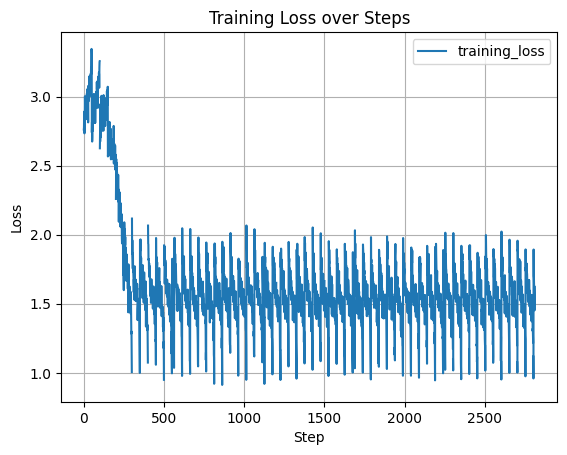

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert log history into DataFrame
history = trainer.state.log_history
df = pd.DataFrame(history)

# Plot training loss over steps
plt.figure()
plt.plot(df['step'], df['loss'], label='training_loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 1.5584052801132202, 'eval_rouge1': 0.7270812176140697, 'eval_rouge2': 0.4973094636191595, 'eval_rougeL': 0.6509636066797538, 'eval_rougeLsum': 0.6756576332376831, 'eval_runtime': 141.7379, 'eval_samples_per_second': 0.353, 'eval_steps_per_second': 0.353}


In [28]:
import shutil

shutil.make_archive('models', 'zip', '/kaggle/working/out/')

'/kaggle/working/models.zip'

In [29]:
from IPython.display import FileLink
FileLink(r'models.zip')

/kaggle/working/models.zip

In [30]:
def generate_response(model, tokenizer, question, context):
    prompt = generate_prompt(question, context)
    answer = answer_query(model, prompt)
    return answer

In [31]:
# Replace 'input_text' with your actual input
context = """
FLAN is the instruction-tuned version of LaMDA-PT. The instruction tuning pipeline mixes all datasets and randomly samples from each dataset as described. To balance the different sizes of datasets, the number of training examples per dataset is limited to 30k and the examples-proportional mixing scheme from T5 is followed with a mixing rate maximum of 3k. All models are fine-tuned for 30k gradient steps with a batch size of 8,192 tokens using the Adafactor Optimizer with a learning rate of 3e-5. The input and target sequence lengths used in finetuning are 1024 and 256, respectively. Packing is used to combine multiple training examples into a single sequence, separating inputs from targets using a special EOS token. This instruction tuning takes around 60 hours on a TPUv3 with 128 cores.
"""

question = "What is the maximum number of training examples used per dataset in FLAN's instruction tuning pipeline?"

# Tokenize the input
answer = generate_response(model, tokenizer, question, context)

print(answer)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 3k
